# cash and carry

## functions

In [1]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from xbbg import blp
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

path = 'MBS_DATA'

def read_tba_prices(tba_symbol = "FNCL", coupon= 4):
    """
    Read TBA prices from the stored CSV file.
    
    :param coupon: Coupon rate to differentiate storage location
    :return: Pandas DataFrame with indexed dates and TBA prices
    """
    
    file_path = f"{path}/{tba_symbol}/{coupon:.1f}/prices.csv"
    if os.path.exists(file_path):
        return pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f"File {file_path} does not exist.")
        return None
    

def read_settle_dates(tba_symbol = 'FNCL'):
    """
    Read settle dates from the saved CSV file and return as a pandas Series.

    :return: Pandas Series with TBA names as index and settlement dates as values.
    """
    settle_dates_path = f"{path}/{tba_symbol}/settle_dates.csv"
    if os.path.exists(settle_dates_path):
        df = pd.read_csv(settle_dates_path, index_col=0, parse_dates=[1])
        return df.iloc[:, 0]  # Convert DataFrame column to Series
    else:
        raise FileNotFoundError(f"Settle dates file not found at {settle_dates_path}")
 

def read_mtg_rate():
    mtg_rates = pd.read_csv(f'{path}/mtg_rate.csv', index_col=0, parse_dates=True)
    return mtg_rates['US 30Y FRM'], mtg_rates['US 15Y FRM'] 


def read_repo():
    repo_rate = pd.read_csv(f'{path}/repo_ffund.csv', index_col=0, parse_dates=True).iloc[:,0]
    return repo_rate


def update_calendar():
    """
    Update the repo file with FEDL01 Index rates up to today using Bloomberg.
    Only fetches missing dates and does nothing if already up to date.
    
    Args:
        path (str): Directory path to the 'repo_ffund.csv' file.
    
    Returns:
        pd.Series: Updated repo rate series.
    """
    today = pd.Timestamp.today().normalize()
    
    # Load existing repo series
    repo_series = read_repo()
    last_date = repo_series.index[-1].normalize()
    
    if last_date >= today:
        print("Repo series is already up to date.")
        return None

    start_date = (last_date + timedelta(days=1)).strftime('%Y-%m-%d')
    end_date = today.strftime('%Y-%m-%d')
    
    # Fetch only missing data from Bloomberg
    new_data = blp.bdh(
        'FEDL01 Index',
        'PX_LAST',
        start_date,
        end_date,
        calendarCodeOverride='US'
    )

    if len(new_data) == 0 or new_data is None:
        print("No new data to add.")
        return repo_series

    # Append new data and save
    new_data = new_data.iloc[:,0]
    new_data.index = pd.to_datetime(new_data.index)
    updated_series = pd.concat([repo_series, new_data])
    updated_series.to_csv(f'{path}/repo_ffund.csv')

    print(f"Repo series updated with {len(new_data)} new records.")
    return None


def read_cpr(tba_symbol):
    cprs = pd.read_csv(f"{path}/{tba_symbol}/cprs.csv", index_col=0, parse_dates=True)
    cprs.columns = cprs.columns.map(float)
    return cprs


def calculate_cpr(coupon,mortgage_rate):
    
    alpha=2.5
    results=0.05 +(0.40-0.10)*(1/(1+np.exp(-alpha*(coupon-mortgage_rate))))
    return results*100


def forward_mbs_price(
    t, T, P_t, coupon, r, CPR, N0=1, MTG_MATURITY=360
):
    """
    Compute the forward price of an MBS bond.

    :param t: Current date (datetime object)
    :param T: Settlement date (datetime object)
    :param P_t: Spot clean price at time t
    :param coupon: Annual coupon rate (in decimal form, e.g., 0.04 for 4%)
    :param r: Repo rate (simple, in decimal form)
    :param CPR: Constant prepayment rate (decimal form)
    :param N0: Initial balance (default = 100)
    :param MTG_MATURITY: Remaining mortgage maturity in months (default = 360)
    :return: Forward price F_{t,T}
    """
    
    # Monthly Coupon
    CPN = coupon/100/ 12
    P_t = P_t /100
    r = r/100
    CPR = CPR/100


    # Determine previous and next coupon payment dates
    prev_coupon_date = pd.Timestamp(year=t.year, month=t.month, day=25) - pd.DateOffset(months=1)
    next_coupon_date = pd.Timestamp(year=t.year, month=t.month, day=25)

    prev_coupon_date_T = pd.Timestamp(year=T.year, month=T.month, day=25) - pd.DateOffset(months=1)
    next_coupon_date_T = pd.Timestamp(year=T.year, month=T.month, day=25)
    
    # Ensure next coupon date is strictly after t
    if next_coupon_date <= t:
        prev_coupon_date += pd.DateOffset(months=1)
        next_coupon_date += pd.DateOffset(months=1)

    # Accrued Interest
    AI = CPN * ((t - prev_coupon_date).days / (next_coupon_date - prev_coupon_date).days)
    AI_fwd = CPN * ((T - prev_coupon_date_T).days / (next_coupon_date_T - prev_coupon_date_T).days)
    # Dirty Price
    dirty_price = (P_t + AI)

    # Financing Cost
    financing_cost = dirty_price * r * ((T - t).days / 365)

    # Determine next coupon payment date t1
    t1 = next_coupon_date

    # Compute N1_tilde (theoretical outstanding principal)
    N1_tilde = N0 * (1 - (1 + CPN) ** -(MTG_MATURITY - 1)) / (1 - (1 + CPN) ** -MTG_MATURITY)

    # Compute N1 (outstanding balance after prepayment)
    N1 = N1_tilde * (1 - CPR) ** (1 / 12)

    # Coupon Income
    CF = N0 * (1 + CPN) - N1
    coupon_income = CF * (1 + r * ((T - t1).days / 365))

    # Forward Price Calculation
    F_t_T = dirty_price + financing_cost - coupon_income
     
    F_t_T = (N0/N1*F_t_T)
    return (F_t_T - AI_fwd)*100


################

# Global variable CALENDAR
update_calendar()
CALENDAR = pd.Series(read_repo().index)


def next_business_day(date):
    """Return the next business day following the given date."""
    future_dates = CALENDAR[CALENDAR > date]
    if future_dates.empty:
        raise ValueError("No future business day available.")
    return future_dates.iloc[0]


def prev_business_day(date):
    """Return the previous business day before the given date."""
    past_dates = CALENDAR[CALENDAR < date]
    if past_dates.empty:
        raise ValueError("No previous business day available.")
    return past_dates.iloc[-1]


def plus_bd(date, n):
    """Add or subtract n business days from date using CALENDAR."""
    if date not in CALENDAR.values:
        date = next_business_day(date)
    idx = CALENDAR[CALENDAR == date].index[0]
    new_idx = idx + n
    if new_idx < 0 or new_idx >= len(CALENDAR):
        raise IndexError("Date out of bounds in calendar.")
    return CALENDAR.iloc[new_idx]


def accrued_interest(date: pd.Timestamp, coupon: float) -> float:
    """
    Calculate accrued interest for an MBS using Actual/Actual between payments.

    Args:
        date (pd.Timestamp): Settlement date.
        coupon (float): Annual coupon rate (e.g., 5.5 for 5.5%).

    Returns:
        float: Accrued interest per $100 face value.
    """
    coupon = coupon/100
    if date.day >= 25:
        prev_coupon_month = date.month
        prev_coupon_year = date.year
    else:
        prev_coupon_month = date.month - 1 or 12
        prev_coupon_year = date.year if date.month != 1 else date.year - 1

    tentative_prev_coupon = pd.Timestamp(prev_coupon_year, prev_coupon_month, 25)
    prev_coupon_date = (next_business_day(tentative_prev_coupon)
                        if tentative_prev_coupon not in CALENDAR.values
                        else tentative_prev_coupon)

    # Next payment is simply the 25th of the next month
    next_coupon_month = prev_coupon_date.month % 12 + 1
    next_coupon_year = prev_coupon_date.year + (prev_coupon_date.month // 12)
    tentative_next_coupon = pd.Timestamp(next_coupon_year, next_coupon_month, 25)
    next_coupon_date = (next_business_day(tentative_next_coupon)
                        if tentative_next_coupon not in CALENDAR.values
                        else tentative_next_coupon)

    # Actual/Actual between payments
    days_since_prev = (date - prev_coupon_date).days
    days_between_coupons = (next_coupon_date - prev_coupon_date).days

    accrued_interest = (coupon / 12) * (days_since_prev / days_between_coupons)

    return round(accrued_interest, 8)


def get_dates(t, T):
    """
    Generate an array of dates starting with t, ending with T, and all payment dates (25th of each month)
    in between, adjusted to next business day if needed.
    """
    dates = [t]
    current_date = t

    # First payment date: the 25th of t's month
    first_payment_date = pd.Timestamp(t.year, t.month, 25)
    if first_payment_date < t:
        # Move to the 25th of the next month
        year = t.year + (t.month // 12)
        month = (t.month % 12) + 1
        first_payment_date = pd.Timestamp(year, month, 25)

    # Adjust to next business day if needed
    if first_payment_date not in CALENDAR.values:
        first_payment_date = next_business_day(first_payment_date)

    # Add all payment dates until T
    while first_payment_date < T:
        dates.append(first_payment_date)
        year = first_payment_date.year + (first_payment_date.month // 12)
        month = (first_payment_date.month % 12) + 1
        next_payment_date = pd.Timestamp(year, month, 25)
        if next_payment_date not in CALENDAR.values:
            next_payment_date = next_business_day(next_payment_date)
        first_payment_date = next_payment_date

    dates.append(T)

    return np.array(dates, dtype='datetime64[D]')


def get_mbs_notio_series(periods, coupon, MTG_MATURITY, CPR):

    cprs_factor = (1-CPR)**(1/12)
    cprs_factor = np.cumprod(cprs_factor)

    periods = np.arange(periods)
    CPN = coupon/12/100
    N = (1 - (1 + CPN) ** -(MTG_MATURITY - periods)) / (1 - (1 + CPN) ** -MTG_MATURITY) * cprs_factor
    return N


def forward_mbs_price(
    t, T, P_t, coupon, r, CPR, MTG_MATURITY=360, ACT=365
):
    """
    Compute the forward price of an MBS bond.

    :param t: Current date (datetime object)
    :param T: Settlement date (datetime object)
    :param P_t: Spot clean price at time t
    :param coupon: Annual coupon rate (in decimal form, e.g., 0.04 for 4%)
    :param r: Repo rate (simple, in decimal form)
    :param CPR: Constant prepayment rate (decimal form)
    :param N0: Initial balance (default = 100)
    :param MTG_MATURITY: mortgage maturity in months (default = 360)
    :return: Forward price F_{t,T}
    """
    
    # Monthly Coupon
    CPN = coupon/100/ 12
    P_t = P_t /100
    r = r/100
    CPR = CPR/100

    dates = get_dates(t,T)

    # Accrued Interest
    AI = accrued_interest(t, coupon)
    AI_T = accrued_interest(T, coupon)

    periods = len(dates) - 1
    N = get_mbs_notio_series(periods, coupon, MTG_MATURITY, CPR)

    # Dirty Price
    dirty_price = (P_t + AI)
    dt = (dates[1:] - dates[:-1]).astype(float)/ACT
    financing = (dirty_price*r*dt*N).sum()

    # Coupon Income
    CF = N[:-1]*(1 + CPN) - N[1:]
    CF = (CF * (1 + r * ((dates[-1] - dates[1:-1]).astype(float) / 365))).sum()

    # Forward Price Calculation
    F_t_T = dirty_price + financing - CF
     
    F_t_T = F_t_T/N[-1]
    return (F_t_T - AI_T)*100


################


def compute_forward_mbs_prices(tba_symbol, coupon_list, repo_rate,
        cprs, cprs_model, roll_days=4, tba_position=1, settle_dates=None):
    """
    Compute forward MBS prices for each coupon using market expectations before settlement.

    :param tba_symbol: The TBA symbol (e.g., 'FNCL')
    :param coupon_list: List of available coupons
    :param repo_rate: Pandas Series of repo rates indexed by date
    :return: DataFrame with forward prices (dates as index, coupons as columns)
    """
    start = settle_dates[0] - pd.DateOffset(days= 2* roll_days)
    end = settle_dates[-1]
    missing = pd.DataFrame(index = pd.date_range(start, end), columns=coupon_list)

    s = -(roll_days+1)
    trading_days = repo_rate.index.to_series()

    # Initialize DataFrame to store forward prices
    basis_tab = pd.DataFrame()
    cpr_tab = pd.DataFrame()
    
    for coupon in coupon_list:
        # Read TBA price data for this coupon
        prices = read_tba_prices(tba_symbol, coupon)
        if prices is None or prices.empty:
            print(f"Skipping coupon {coupon}: No price data available.")
            continue
        
        # Initialize list to store results for this coupon
        coupon_prices = []
        
        for i in range(len(settle_dates) - tba_position):  # Ensure we have a next settlement date
            ts = settle_dates[i]  # Current settlement date
            if ts  not in trading_days : continue 
            
            ts_next = settle_dates[i + tba_position]  # Next settlement date
            # Get s trading days before ts
            prior_dates = trading_days.loc[:ts].index[s:-1]

            # Compute forward price for each prior date
            for date in prior_dates:
                if date not in prices.index : 
                    fwd_price = np.nan  # If missing data, fill with NaN
                    CPR_adjustment = np.nan
                    P_next = np.nan
                    missing.loc[date, coupon] = 'date'

                else : 
                
                    tba_current = f"{tba_symbol} {coupon} {ts.strftime('%m/%y')} Mtge"
                    tba_next = f"{tba_symbol} {coupon} {ts_next.strftime('%m/%y')} Mtge"
                    payment_date = pd.Timestamp(year=ts.year, month=ts.month, day=25)

                    P_t = prices.loc[date].get(tba_current, np.nan)
                    P_next = prices.loc[date].get(tba_next, np.nan)
                    #P_next_at_payment_date = prices.loc[payment_date:].iloc[0].get(tba_next, np.nan)
                    r = repo_rate.get(date, np.nan)
                    CPR_model = cprs_model.loc[ts].get(coupon, np.nan) 
                    CPR_model = CPR_model*np.ones(tba_position+1)
                    CPR_model[0] = 0
                    if np.isnan(P_t) or np.isnan(P_next) or np.isnan(r) or np.isnan(CPR_model[-1]):
                        fwd_price = np.nan  # If missing data, fill with NaN
                        CPR_adjustment = np.nan
                        if np.isnan(P_t) : 
                            missing.loc[date, coupon] = 'P_t'
                        elif np.isnan(P_next) : 
                            missing.loc[date, coupon] = 'P_next'

                        elif np.isnan(r) : 
                            missing.loc[date, coupon] = 'repo'
                        elif np.isnan(CPR_model[-1]) : 
                            missing.loc[date, coupon] = 'cpr'
                    else:  
                                   
                        fwd_price = forward_mbs_price(ts, ts_next, P_t, coupon, r, CPR=CPR_model)
                        if np.isnan(fwd_price):
                            missing.loc[date, coupon] = 'fwd_func'

                        CPR = cprs.loc[ts:ts_next, coupon].shift(1).values
                        CPR[0] = 0
                        fwd_price_realised = forward_mbs_price(ts, ts_next, P_t, coupon, r, CPR=CPR)
                        CPR_adjustment = fwd_price_realised - fwd_price
                        #accrued = coupon/12*(ts_next - payment_date).days/30
                        #N1_estimated = (1 - CPR_model/100)**(1/12)
                        #N1 = (1 - CPR/100)**(1/12)
                        #CPR_adjustment = (P_next_at_payment_date+accrued - 100)*(N1_estimated-N1)/N1_estimated
                    
                coupon_prices.append(
                    {"Date": date, 
                     "Coupon": coupon,
                     "dcpr" : CPR_adjustment*100, 
                     "basis": (fwd_price - P_next)*100
                     })
    
        # Convert list to DataFrame and pivot
        coupon_prices = pd.DataFrame(coupon_prices)
        coupon_df_cpr = coupon_prices.pivot(index="Date", columns="Coupon", values="dcpr")
        coupon_df_basis =coupon_prices.pivot(index="Date", columns="Coupon", values="basis")    
        # Merge into final DataFrame
        cpr_tab = cpr_tab.join(coupon_df_cpr, how='outer') if not cpr_tab.empty else coupon_df_cpr
        basis_tab = basis_tab.join(coupon_df_basis, how='outer') if not basis_tab.empty else coupon_df_basis
    
    return cpr_tab, basis_tab, missing



def score_backtest(basis_tab, cpr_tab, tba_position, threshhold, 
                    verbose=True, weighted=True, start_date=pd.to_datetime('01/01/2010')): 

    basis_tab_grouped = basis_tab.loc[start_date:].groupby(by = lambda x: x+pd.DateOffset(day=13)).mean().dropna(how='all')
    cpr_tab_grouped = cpr_tab.loc[start_date:].groupby(by = lambda x: x+pd.DateOffset(day=13)).mean().dropna(how='all')
    basis_tab_filtered = basis_tab_grouped.where(basis_tab_grouped <= threshhold, np.nan)
    cpr_tab_filtered = cpr_tab_grouped.where(basis_tab_grouped <= threshhold, np.nan)

    if weighted : 
        denom = basis_tab_filtered.sum(axis=1)
        factor = basis_tab_filtered.notna().sum(axis=1)
        weights = basis_tab_filtered.apply(lambda x: x*factor/denom)  
        basis_tab_filtered = basis_tab_filtered*weights      
        cpr_tab_filtered = cpr_tab_filtered*weights  

    if verbose :

        stats_all_basis = (basis_tab_grouped).describe().loc[['mean', 'std']]
        basis_values = (basis_tab_grouped).values.flatten()
        basis_values = basis_values[~np.isnan(basis_values)]
        stats_all_basis['agg'] = [basis_values.mean(), basis_values.std()]

        stats_neg_basis = (basis_tab_filtered).describe().loc[['mean', 'std']]
        basis_values = (basis_tab_filtered).values.flatten()
        basis_values = basis_values[~np.isnan(basis_values)]
        stats_neg_basis['agg'] = [basis_values.mean(), basis_values.std()] 
        display(stats_neg_basis)

        unexplain = (-cpr_tab_filtered).mean(axis=1).fillna(0)
        pnl = (-basis_tab_filtered).mean(axis=1).fillna(0)

        df = pd.concat((pnl, unexplain), axis=1)
        df['agg'] = pnl+unexplain
        df = df/tba_position
        df.columns = ['pnl', 'unexplain', 'agg']
        
        display(df.describe(percentiles=[]))
        df['agg'].cumsum().plot()

        n_basis = basis_tab_filtered.notna().sum(axis=1)
        result = {
            'pnl annuel' : round(df['agg'].mean()*12 -20-12),
            'n avg basis' : round(n_basis.mean()),
            'missed_month': round((n_basis==0).sum()/len(n_basis)*12)
        }

        display(pd.Series(result))

    else : 
        
        unexplain = (-cpr_tab_filtered).mean(axis=1).fillna(0)
        pnl = (-basis_tab_filtered).mean(axis=1).fillna(0)
        total = (pnl+unexplain)/tba_position
        return total.mean()


def compute_available_capital(allocations):
    """
    Computes the available capital before allocation for each period, given that
    each allocation remains invested for two additional periods.

    Args:
        allocations (np.array): Percentages allocated in each period.

    Returns:
        np.array: Available capital before each allocation.
    """
    periods = len(allocations)
    capital = np.full(periods, 1.0)  # Start with 100% capital available
    adjustments = np.zeros(periods)  # To track allocated capital over time

    for t in range(periods):
        if t > 0:
            capital[t] = 1 - adjustments[t]  # Adjust available capital

        # Compute allocation for the current period
        allocation_amount = capital[t] * (allocations[t])

        # Deduct allocation over the next two periods
        if t + 1 < periods:
            adjustments[t + 1] += allocation_amount
        if t + 2 < periods:
            adjustments[t + 2] += allocation_amount
        
        

    return capital
    

def merge_basis(basis_tab_current, cpr_tab_current, basis_tab_forward, 
                cpr_tab_forward, threshhold, verbose=False, start_date=pd.to_datetime('01/01/2010')) : 

    basis_tab_forward.columns = 100 + basis_tab_current.columns
    cpr_tab_forward.columns = basis_tab_forward.columns

    basis_tab = pd.concat((basis_tab_current,basis_tab_forward/3), axis=1)
    cpr_tab = pd.concat((cpr_tab_current,cpr_tab_forward/3), axis=1)

    basis_tab_grouped = basis_tab.loc[start_date:].groupby(by = lambda x: x+pd.DateOffset(day=13)).mean().dropna(how='all')
    cpr_tab_grouped = cpr_tab.loc[start_date:].groupby(by = lambda x: x+pd.DateOffset(day=13)).mean().dropna(how='all')
    basis_tab_filtered = basis_tab_grouped.where(basis_tab_grouped <= threshhold, np.nan)
    cpr_tab_filtered = cpr_tab_grouped.where(basis_tab_grouped <= threshhold, np.nan)

    denom = basis_tab_filtered.sum(axis=1)
    weights = basis_tab_filtered.apply(lambda x: x/denom)

    fwd_allocations = weights.loc[:, 102.5:].sum(axis=1)
    capital = compute_available_capital(fwd_allocations.values)
    weights = weights.apply(lambda x: x*capital)

    basis_tab_filtered.loc[:, 102.5:] = 3*basis_tab_filtered.loc[:, 102.5:]
    cpr_tab_filtered.loc[:, 102.5:] = 3*cpr_tab_filtered.loc[:, 102.5:]

    unexplain = (-cpr_tab_filtered*weights).sum(axis=1).fillna(0)
    pnl = (-basis_tab_filtered*weights).sum(axis=1).fillna(0)
    total = (pnl+unexplain)
    if verbose : 
        df = pd.concat((pnl, unexplain), axis=1)
        df['agg'] = pnl+unexplain
        df = df
        df.columns = ['pnl', 'unexplain', 'agg']
        
        display(df.describe(percentiles=[]))
        df['agg'].cumsum().plot()

        n_basis = basis_tab_filtered.notna().sum(axis=1)
        result = {
            'pnl annuel' : round(df['agg'].mean()*12 -20-12),
            'n avg basis' : round(n_basis.mean()),
            'missed_month': round((n_basis==0).sum()/len(n_basis)*12)
        }

        display(pd.Series(result))

        per_coupon = (-(basis_tab_filtered + cpr_tab_filtered)*weights).fillna(0)
        display(per_coupon.mean())
        print(per_coupon.loc[:, :7].sum(axis=1).mean(), per_coupon.loc[:, 102.5:107].sum(axis=1).mean())

    else : return total.mean()
 


Repo series is already up to date.


## backtest

In [2]:
tba_symbol = "G2SF"
ALL_CPNS = np.arange(2.5, 7.5, 0.5)
coupon_list = ALL_CPNS
repo_rate = read_repo() + 0.15
cprs = read_cpr(tba_symbol)
mtg_rates, _ = read_mtg_rate()
start_date = pd.to_datetime('01/01/2010')


settle_dates = read_settle_dates(tba_symbol)
future_cpr = (cprs.loc[settle_dates[settle_dates<cprs.index[-1]].values]
                                .dropna(how='all'))
three_month_avg_cpr = future_cpr.shift(1).rolling(window=3).mean().dropna(how='all')
dates = three_month_avg_cpr.index

mtg_rates_dates = mtg_rates.reindex(mtg_rates.index.union(dates)).interpolate(method='linear').loc[dates]
cprs_model_gross = three_month_avg_cpr.apply(lambda x : calculate_cpr(x.name, mtg_rates_dates))

####
dates = dates[3:]
future_cpr = future_cpr.loc[dates]
cprs_model_gross = cprs_model_gross.loc[dates]


In [12]:
roll_days = 2
tba_position = 1
w = 100/100
cprs_model = (1-w)*three_month_avg_cpr + w*cprs_model_gross



cpr_tab_current, basis_tab_current, missing_current = compute_forward_mbs_prices(
    tba_symbol, ALL_CPNS, repo_rate, future_cpr, cprs_model, 
    roll_days=roll_days, tba_position=tba_position, settle_dates=dates)


roll_days = 2
tba_position = 3
cpr_tab_forward, basis_tab_forward, missing_forward = compute_forward_mbs_prices(
    tba_symbol, ALL_CPNS, repo_rate, future_cpr, cprs_model, 
    roll_days=roll_days, tba_position=tba_position, settle_dates=dates)



### debug missing 

In [14]:
missing_current.describe()

,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0
count,78,66,42,18,0,34,86,96,118,216
unique,3,3,1,1,0,3,3,3,3,3
top,date,date,cpr,cpr,NaN,P_t,P_t,P_t,P_t,date
freq,58,36,42,18,NaN,16,42,48,58,156


In [171]:
coupon = 7
missing[coupon].dropna()

2010-12-10    P_next
2011-02-09    P_next
2011-03-09    P_next
2011-04-12      date
2011-05-11       P_t
               ...  
2023-02-10      date
2023-03-10      date
2023-04-12      date
2023-05-10       P_t
2023-06-12       P_t
Name: 7.0, Length: 102, dtype: object

<Axes: >

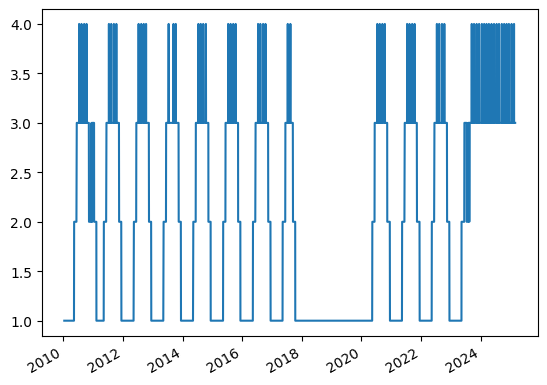

In [179]:
read_tba_prices(coupon=7).apply(lambda x:len(x.dropna()), axis=1).plot()

In [ ]:
date = pd.to_datetime('03/10/2021')
ts = settle_dates[settle_dates>=date].iloc[0]
ts_next = settle_dates[settle_dates>=date].iloc[tba_position]
tba_current = f"{tba_symbol} {coupon} {ts.strftime('%m/%y')} Mtge"
tba_next = f"{tba_symbol} {coupon} {ts_next.strftime('%m/%y')} Mtge"
prices =  read_tba_prices(tba_symbol, coupon)
P_t = prices.loc[date, tba_current]
P_t = prices.loc[date, tba_next]

r = repo_rate.loc[date]
CPR = cprs_model.loc[ts, coupon]
ts, ts_next, P_t, r, CPR

In [147]:
cprs_model[2.5].dropna()

2013-10-10    4.266774
2013-11-13    4.180625
2013-12-11    4.068842
2014-01-13    3.926582
2014-02-13    3.964271
                ...   
2024-10-15    4.994279
2024-11-14    4.794559
2024-12-12    4.837187
2025-01-14    4.727468
2025-02-13    4.770180
Name: 2.5, Length: 137, dtype: float64

In [ ]:
forward_mbs_price(ts, ts_next, P_t, coupon, r, CPR)

NameError: name 'date' is not defined

### backtest

#### Current

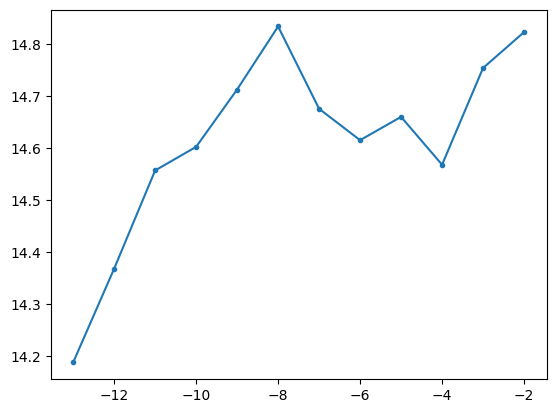

In [15]:
thresholds = np.arange(-13, -1, 1)
g1 = [score_backtest(basis_tab_current, cpr_tab_current, tba_position=1, threshhold=t, 
                     verbose=False, weighted=True, start_date=start_date) 
      for t in thresholds]

plt.plot(thresholds, g1, marker='.')

Coupon,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,agg
mean,-26.366505,-24.197066,-24.759050,-22.631596,-18.997890,-25.162444,-20.031796,-38.755904,-62.694910,-36.469618,-25.767850
std,33.651853,16.979065,35.729742,20.054524,9.016127,15.325049,8.752982,27.527017,45.185623,22.160882,22.615107


,pnl,unexplain,agg
count,175.000000,175.000000,175.000000
mean,14.240534,-1.193081,13.047453
std,20.083018,9.147726,21.667589
min,0.000000,-30.190262,-8.151700
50%,11.023717,0.000000,4.702089
max,152.731712,29.962864,157.725304


pnl annuel      125
n avg basis       2
missed_month      5
dtype: int64

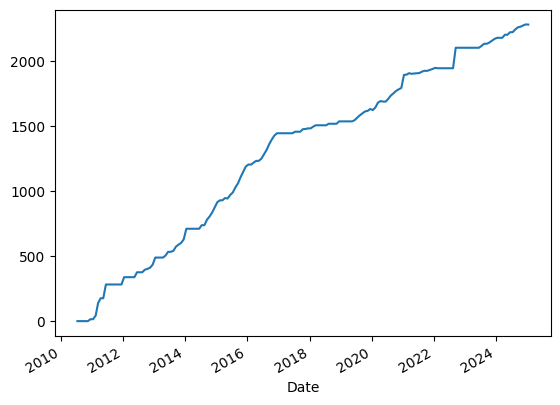

In [17]:
score_backtest(basis_tab_current, cpr_tab_current, tba_position=1, threshhold=-8, verbose=True, weighted=False)

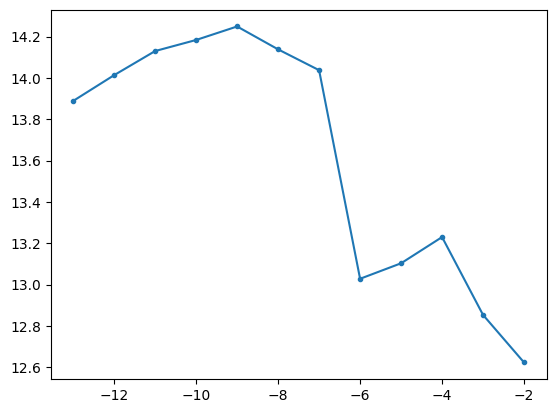

In [ ]:


g2 = [merge_basis(basis_tab_current, cpr_tab_current, 
                  basis_tab_forward, cpr_tab_forward, 
                  threshhold=t, verbose=False)
        for t in thresholds]

plt.plot(thresholds, g2, marker='.')

,pnl,unexplain,agg
count,175.000000,175.000000,175.000000
mean,15.056216,-0.807417,14.248799
std,21.247369,10.476913,24.192918
min,0.000000,-30.900886,-7.315751
50%,9.784250,0.000000,1.377510
max,152.731712,43.960176,157.725304


pnl annuel      139
n avg basis       2
missed_month      5
dtype: int64

Coupon
2.5      0.670009
3.0      0.114513
3.5      0.189107
4.0      0.219301
4.5      0.621270
5.0      0.662723
5.5      0.812133
6.0      0.409046
6.5      2.329097
7.0      3.748567
102.5    0.516595
103.0    0.137130
103.5    0.267404
104.0    0.253979
104.5    0.535387
105.0    0.594565
105.5    0.861278
106.0    0.582588
106.5    0.649078
107.0    0.075027
dtype: float64

9.775766767782168 4.473032238997443


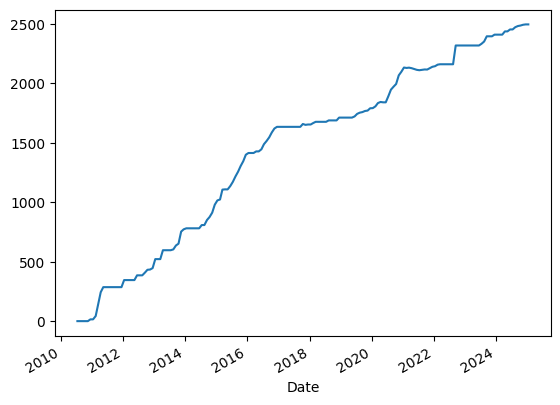

In [ ]:
merge_basis(basis_tab_current, cpr_tab_current, 
            basis_tab_forward, cpr_tab_forward, 
            threshhold=-9, verbose=True)

## cpr calculation

In [156]:
CPN = 6/100/12
MTG_MATURITY = 340
periods = np.arange(MTG_MATURITY)

N0=1

# Compute N1_tilde (theoretical outstanding principal)
N_tilde = N0 * (1 - (1 + CPN) ** -(MTG_MATURITY - periods)) / (1 - (1 + CPN) ** -MTG_MATURITY)

In [157]:
pd.Series(N_tilde).to_clipboard()

## debug

In [9]:
coupon = 5
r = 0
set_date_1 = pd.to_datetime('01/13/2024')
set_date_2 = pd.to_datetime('02/13/2024')
spot_price = 100
yearly_cpr = 10
roll_date = 13


In [70]:
Y = np.arange(0,60,1)

In [87]:
me = np.array([forward_mbs_price(
    set_date_1, set_date_2, spot_price, coupon, r, y
) for y in Y])


samy = np.array([100*calculate_current_forward(
    set_date_1, 1, spot_price/100, coupon, r, y/100, 13 
) for y in Y])

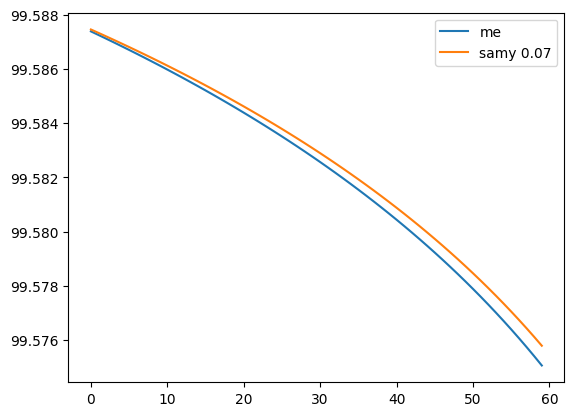

In [88]:
from matplotlib import pyplot as plt
plt.plot(Y, me, label='me')
plt.plot(Y, samy, label=f'samy {round((samy-me).max()*100, 2)}')
plt.legend()

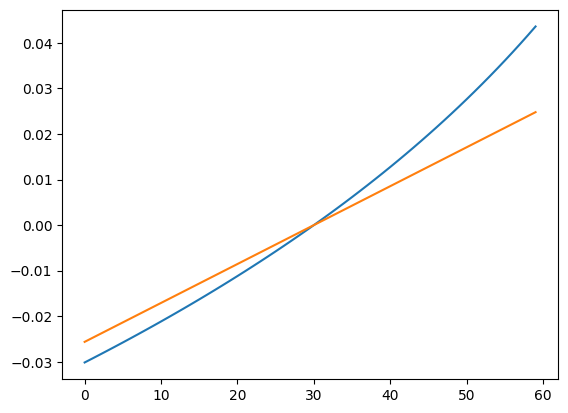

In [20]:
z=30
YZ = Y+z-30

N1_estimated = (1 - z/100)**(1/12)
N1 = (1 - YZ/100)**(1/12)

ajust_1 = (N1_estimated-N1)/N1_estimated
ajust_2 = (YZ-z)/(1200-z)

plt.plot(YZ, ajust_1)
plt.plot(YZ, ajust_2)

$ù## new 